In [1]:
import optax
import json

import jax.numpy as np
import matplotlib.pyplot as plt

from jax import vmap, jit, hessian, grad
from xpinn import XPINN
from base_network import neural_network
from pathlib import Path
from utils import data_path, model_path
from type_util import Array

In [2]:
activation = np.tanh
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [4]:


Decomp_file_test = data_path / "NavierStokes" / "test_Decomp.json"
NoDecomp_file_test = data_path / "NavierStokes" / "test_NoDecomp.json"

single_pinn = XPINN(NoDecomp_file_test, activation)
xpinn = XPINN(Decomp_file_test, activation)

No decomp models

In [32]:
no_decomp_path = model_path / "NavierStokes" / "NoDecomp" / "laminar"
#models\NavierStokes\NoDecomp\laminar\ADAM_20000_iter_9layer\model0
ND_adam_20000_iter_9layer = no_decomp_path / "ADAM_20000_iter_9layer" / "model0"
#models/NavierStokes/NoDecomp/laminar/Pretrained_ADAM_20000_iter_8layer
ND_adam_pretrained_20000_iter_8layer = no_decomp_path / "Pretrained_ADAM_20000_iter_8layer"/ "model1" 
#models\NavierStokes\NoDecomp\laminar\NoCylinder\ADAM_20000_iter_8layer
ND_adam_no_cylinder_20000_iter_8layer = no_decomp_path / "NoCylinder" / "ADAM_20000_iter_8layer"
#models\NavierStokes\single_pinn\laminar\Adam_20000_iter_7layer_model0
ND_adam_20000_iter_good_model = model_path / "NavierStokes" / "single_pinn" / "laminar" / "Adam_20000_iter_7layer_model0"

Decomp models

In [47]:
decomp_path = model_path / "NavierStokes" / "Decomp" / "laminar"
#models\NavierStokes\Decomp\laminar\ADAM_20000_iter_7layer
D_adam_20000_iter_7layer = decomp_path / "ADAM_20000_iter_7layer"
#models\NavierStokes\Decomp\laminar\NoCylinder\ADAM_20000_iter_8layer
D_adam_no_cylinder_20000_iter_8layer = decomp_path / "NoCylinder" / "ADAM_20000_iter_8layer" #this model is named wrong. its 7layer


In [46]:
single_pinn.load_model(ND_adam_no_cylinder_20000_iter_8layer)

(20, 2) (20,)
(20, 20) (20,)
(20, 20) (20,)
(20, 20) (20,)
(20, 20) (20,)
(20, 20) (20,)
(20, 20) (20,)
(20, 20) (20,)
(2, 20) (2,)


In [54]:
xpinn.load_model(D_adam_no_cylinder_20000_iter_8layer)

In [55]:
n_iter = 200000


Text(0.5, 1.0, 'Loss over 200000 epochs')

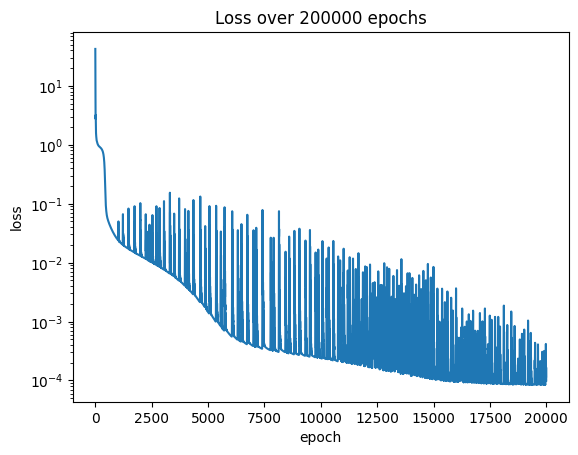

In [56]:
a_losses = single_pinn.losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

plt.plot(t, a_losses[0, t_0:t_end])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title(f"Loss over {n_iter} epochs")

Text(0.5, 1.0, 'Loss over 200000 epochs')

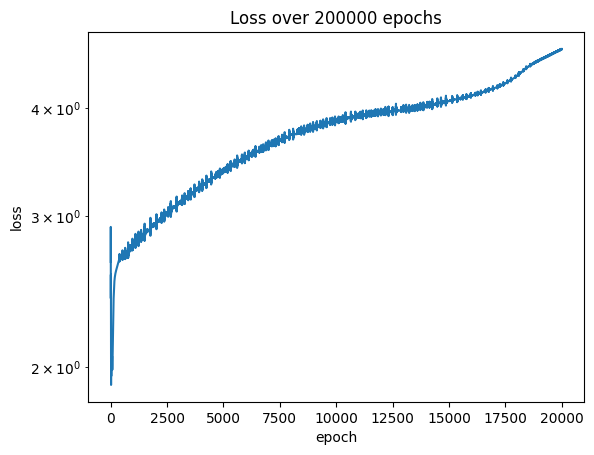

In [57]:
a_losses = xpinn.losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

plt.plot(t, a_losses[0, t_0:t_end])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.title(f"Loss over {n_iter} epochs")

In [50]:
a_losses[0][-1]

Array(0.0543379, dtype=float32)

In [14]:
psi = lambda params, xy: model(params, xy)[0]
p = lambda params, xy: model(params, xy)[1]

hess_psi = hessian(psi, argnums=1)
d_psi_dxy = grad(psi, argnums=1)
def uv(params, xy):
    v_negated, u = d_psi_dxy(params, xy)
    return np.array([u, -v_negated])

uv = jit(vmap(uv, (None, 0)))
p = jit(vmap(p, (None, 0)))
j_model = jit(v_model)

In [15]:
def pinn_predict(params, args: dict[str, Array]):
    b = args["boundary"]
    i = args["interior"]
    if b.size == 0:
        points = i
    else:
        points = np.vstack([b, i])

    net_output = j_model(params, points)
    pressure = net_output[:, 1]
    #pressure = p(params, points)
    streamfunction = net_output[:, 0]
    flow = uv(params, points)
    flow_magnitude = np.sqrt(np.sum(flow**2, axis=1))

    return points, flow, flow_magnitude, pressure, streamfunction

In [19]:
def predict(xpinn, input_file: str | Path = None):
    if input_file:
        main_args = {}
        with open(input_file) as infile:
            data = json.load(infile)

        for i, item in enumerate(data["XPINNs"]):
            interior = np.asarray(item["Internal points"])
            boundary = np.asarray(item["Boundary points"])

            main_args[i] = {"boundary": boundary, "interior": interior}

    else:
        main_args = xpinn.main_args

    total_streamfunction = []
    total_points = []
    total_flow = []
    total_p = []
    total_flow_magnitude = []


    for i, pinn in enumerate(xpinn.PINNs):
        params = pinn.params
        points, flow, flow_magnitude, p, streamfunction = pinn_predict(params, main_args[i])
        
        total_flow_magnitude.append(flow_magnitude)
        total_streamfunction.append(streamfunction)
        total_points.append(points)
        total_flow.append(flow)
        total_p.append(p)

    return total_points, total_flow, total_flow_magnitude, total_p, total_streamfunction

In [41]:
points, flow, flow_magitude, pressure, streamfunction = predict(single_pinn, NoDecomp_file_test)

In [61]:
points, flow, flow_magitude, pressure, streamfunction = predict(xpinn, Decomp_file_test)

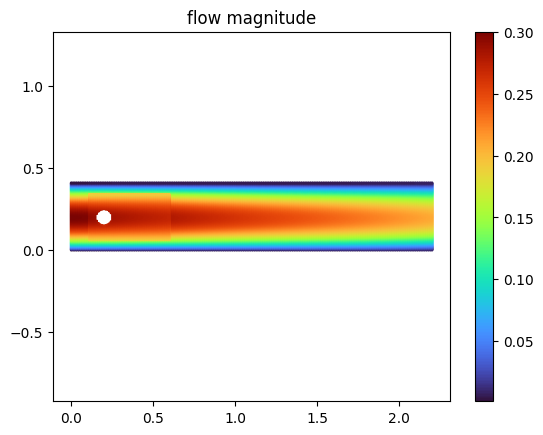

In [62]:
tot_flow_magnitude = np.concatenate(flow_magitude)
min_, max_ = tot_flow_magnitude.min(), tot_flow_magnitude.max()

for point, pred in zip(points, flow_magitude):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="Flow Magnitude", s=1)
plt.title("flow magnitude")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

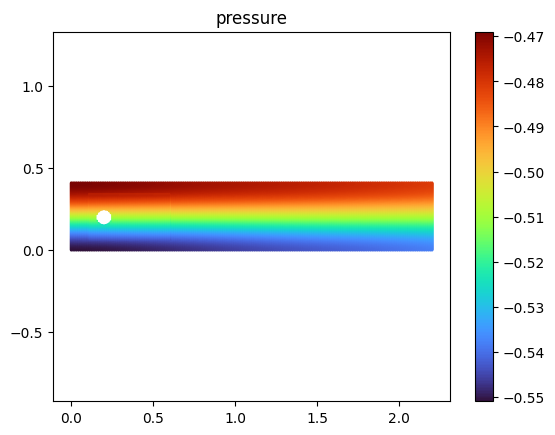

In [63]:
tot_pressure  =  np.concatenate(pressure)
min_, max_ = tot_pressure.min(), tot_pressure.max()

for point, pred in zip(points, pressure):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="pressure", s=1)
plt.title("pressure")
plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()

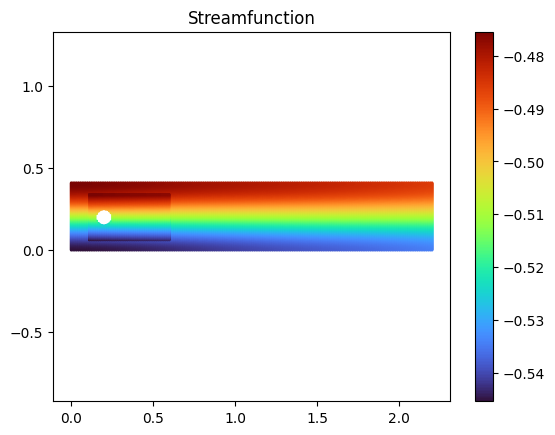

In [64]:
tot_streamfunction = np.concatenate(streamfunction)
in_, max_ = tot_streamfunction.min(), tot_streamfunction.max()


for point, pred in zip(points, streamfunction):
    plt.scatter(point[:,0], point[:,1], c = pred, cmap="turbo", label="streamfunction", s=1)
plt.title("Streamfunction")
#plt.clim(min_, max_)
plt.axis("equal")
plt.colorbar()